# Import necessary libraries

In [57]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import words, stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
nltk.download("wordnet")
nltk.download("words")
nltk.download("stopwords")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger_eng")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

# Download Dataset

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1


In [7]:
# find path to dataset
os.listdir(path)

['IMDB Dataset.csv']

In [8]:
main_path = os.path.join(path, "IMDB Dataset.csv")
main_path

'/root/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1/IMDB Dataset.csv'

In [9]:
# read csv dataset
df = pd.read_csv(main_path)
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [10]:
# check duplicated values
df.duplicated().sum()

np.int64(418)

In [11]:
# remove duplicated values
df = df.drop_duplicates()

# check after removing
df.duplicated().sum()

np.int64(0)

In [12]:
df["review"][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [13]:
df["sentiment"][0]

'positive'

# Preprocess Dataset

In [14]:
# collect stopwords
stopwords_ = set(stopwords.words("english"))

In [15]:
# collect words
words_ = set(words.words())

In [16]:
# initialize lemmatizer
lemmatizer = WordNetLemmatizer()

In [17]:
def get_pos_tag(tag):
  if tag.startswith("V"):
    return wordnet.VERB
  elif tag.startswith("N"):
    return wordnet.NOUN
  elif tag.startswith("J"):
    return wordnet.ADJ
  elif tag.startswith("R"):
    return wordnet.ADV
  else:
    return None

In [18]:
def clean_text(text):
  text = text.lower() # convert to lower case
  text = re.sub(r"[^a-zA-Z0-9 ]", "", text) # remove unnecessary characters
  tokens = word_tokenize(text)

  tokens = [token for token in tokens if token not in stopwords_ ] # remove stopwords
  tokens = [token for token in tokens if token in words_]

  tags = pos_tag(tokens)

  lemmatized_words = []
  for word, tag in tags:
    lemmatized_word = word
    wdnet = get_pos_tag(tag)
    if wdnet:
      lemmatized_words.append(lemmatizer.lemmatize(lemmatized_word, pos=wdnet))
    else:
      lemmatized_words.append(lemmatized_word)

  return " ".join(lemmatized_words)

In [19]:
clean_text(df["review"][0])

'one watch episode hook right exactly first thing struck brutality unflinching violence set right word go trust show faint hearted timid show sex violence classic use nickname give maximum security state mainly emerald city experimental section prison glass face inwards privacy high agenda em city home death dodgy shady never far would say main appeal show due fact go wouldnt dare forget pretty painted forget charm forget doesnt mess around first episode ever saw struck nasty say ready watched taste get accustomed high graphic violence violence injustice crook sell nickel kill order get away well mannered middle class turn prison due lack street prison experience watching may become comfortable uncomfortable get touch side'

# Change DataFrame structure

In [20]:
# apply clean_text function to our texts
df["cleaned_review"] = df["review"].apply(clean_text)

/tmp/ipython-input-1548813169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cleaned_review"] = df["review"].apply(clean_text)


In [21]:
# map labels (positive: 1, negative: 0)
df["cleaned_sentiment"] = df["sentiment"].map({"positive": 1, "negative": 0})

/tmp/ipython-input-3983103029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cleaned_sentiment"] = df["sentiment"].map({"positive": 1, "negative": 0})


In [22]:
df = df[["cleaned_review", "cleaned_sentiment", "review", "sentiment"]]

In [23]:
# final df
df

,cleaned_review,cleaned_sentiment,review,sentiment
0,one watch episode hook right exactly first thi...,1,One of the other reviewers has mentioned that ...,positive
1,wonderful little production technique unassumi...,1,A wonderful little production. <br /><br />The...,positive
2,think wonderful way spend time hot summer week...,1,I thought this was a wonderful way to spend ti...,positive
3,basically there family little boy jake there z...,0,Basically there's a family where a little boy ...,negative
4,petter love time money visually stunning film ...,1,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...,...,...
49995,think movie right good job wasnt creative orig...,1,I thought this movie did a down right good job...,positive
49996,bad plot bad dialogue bad act idiotic annoy gr...,0,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,catholic teach parochial elementary taught hig...,0,I am a Catholic taught in parochial elementary...,negative
49998,go disagree previous comment side one second r...,0,I'm going to have to disagree with the previou...,negative


# Split our dataset into train and test

In [24]:
train_x, test_x, train_y, test_y = train_test_split(df["cleaned_review"], df["cleaned_sentiment"], test_size=0.3, random_state=42)

# Vectorize our features

In [25]:
# initialize vectorizer
vectorizer = TfidfVectorizer()

In [26]:
train_x_ = vectorizer.fit_transform(train_x)
test_x_ = vectorizer.transform(test_x)

# Train models

# LogisticRegression

In [27]:
log_model = LogisticRegression()

In [28]:
log_model.fit(train_x_, train_y)

LogisticRegression()

In [29]:
predict_log = log_model.predict(test_x_)

In [30]:
accuracy_score(predict_log, test_y)

0.8788571428571429

In [31]:
f1_score(predict_log, test_y)

0.8808358682713927

In [32]:
cm_log = confusion_matrix(predict_log, test_y)

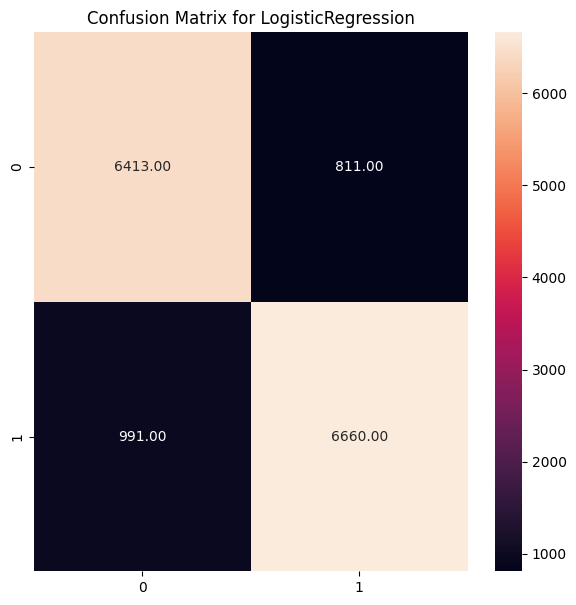

In [33]:
plt.figure(figsize=(7, 7))

sns.heatmap(cm_log, annot=True, fmt=".2f")
plt.title("Confusion Matrix for LogisticRegression")
plt.show()

# Decision Tree Classifier

In [41]:
tree = DecisionTreeClassifier()

In [49]:
tree.fit(train_x_, train_y)

DecisionTreeClassifier()

In [50]:
predict_tree = tree.predict(test_x_)

In [51]:
accuracy_score(predict_tree, test_y)

0.7050084033613445

In [52]:
f1_score(predict_tree, test_y)

0.7062525103762217

In [53]:
cm_tree = confusion_matrix(predict_tree, test_y)

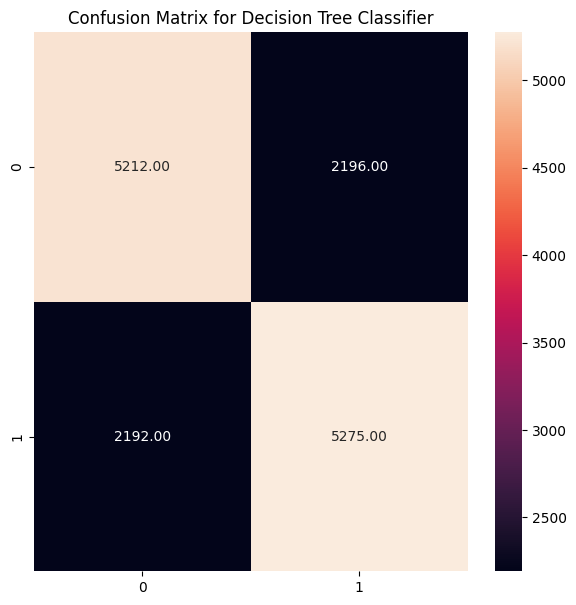

In [54]:
plt.figure(figsize=(7, 7))

sns.heatmap(cm_tree, annot=True, fmt=".2f")
plt.title("Confusion Matrix for Decision Tree Classifier")
plt.show()

# GradientBoosting

In [58]:
boost = GradientBoostingClassifier()

In [59]:
boost.fit(train_x_, train_y)

GradientBoostingClassifier()

In [60]:
predict_boost = boost.predict(test_x_)

In [61]:
accuracy_score(predict_boost, test_y)

0.795563025210084

In [62]:
f1_score(predict_boost, test_y)

0.8083926658685653

In [63]:
cm_boost = confusion_matrix(predict_boost, test_y)

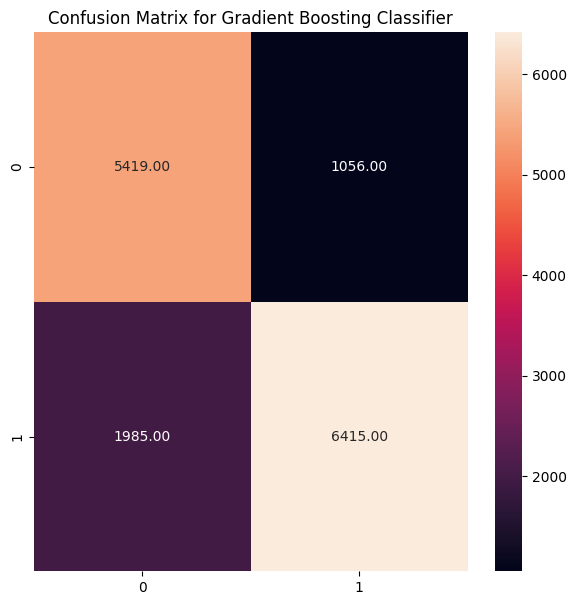

In [64]:
plt.figure(figsize=(7, 7))

sns.heatmap(cm_boost, annot=True, fmt=".2f")
plt.title("Confusion Matrix for Gradient Boosting Classifier")
plt.show()

# Micro Service

In [72]:
def classify_text(text):
  text = clean_text(text)
  text_ = vectorizer.transform([text])
  predict = log_model.predict(text_)

  return predict

In [81]:
classify_text("love")

array([1])

In [84]:
classify_text("lie")

array([0])

In [76]:
classify_text("I hate this movie everytime. I do not watch this movie again. It was a very bad thing in my life")

array([0])

In [77]:
classify_text("I was enjoying to watch this movie. It was an amazing movie. I will watch it again.")

array([1])